In [2]:
#all the required imports
import rawpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2
from scipy.signal import convolve2d
import imageio
import os

In [ ]:

#original image
image = plt.imread('exercise_2_data/01/IMG_9939.JPG')
plt.imshow(image)

# try to find where red cap is manually trial and error
x,y = 2048,1396 #points to red cap approx middle
plt.scatter(x,y, color='red', s=10)

#for blue tip
x,y = 1800,2600
plt.scatter(x,y, color='deepskyblue', s=10)
plt.show()

Loaded array of size (4014, 6020)


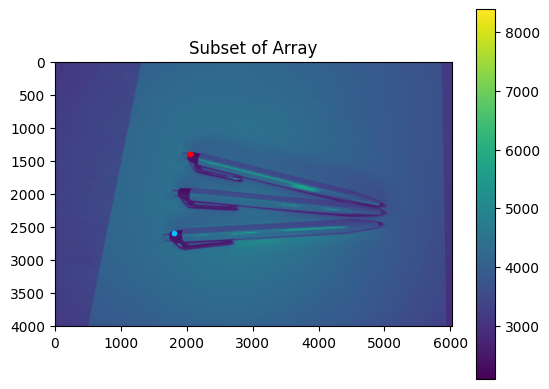

In [3]:
#Load bayers filtered data
array = np.load('exercise_2_data/01/IMG_9939.npy')
print('Loaded array of size', array.shape)

subset = array
plt.imshow(subset)
plt.colorbar()
plt.title('Subset of Array')
x,y = 2048,1396 #points to red cap approx middle
plt.scatter(x,y, color='red', s=10)
#plt.show()

x,y = 1800,2600 #points to red cap approx middle
plt.scatter(x,y, color='deepskyblue', s=10)
plt.show()

[[3361 2596 3352 2614 3389 2603]
 [2829 3371 2854 3405 2815 3378]
 [3382 2614 3380 2608 3389 2598]
 [2833 3370 2894 3374 2844 3347]
 [3416 2590 3406 2598 3402 2606]
 [2836 3327 2837 3415 2822 3370]]
[[4992 3683 5019 3656 5003 3706]
 [3535 4985 3570 4980 3534 4936]
 [5002 3694 5149 3690 5025 3685]
 [3545 4969 3496 5031 3573 4955]
 [5024 3696 5035 3601 5139 3735]
 [3574 5047 3567 4956 3494 5066]]
[[2840 2350 2942 2373 2902 2384]
 [2833 2793 2845 2799 2855 2830]
 [2740 2298 2779 2292 2724 2322]
 [2731 2675 2732 2727 2768 2658]
 [2670 2277 2696 2276 2671 2293]
 [2732 2678 2737 2661 2732 2637]]


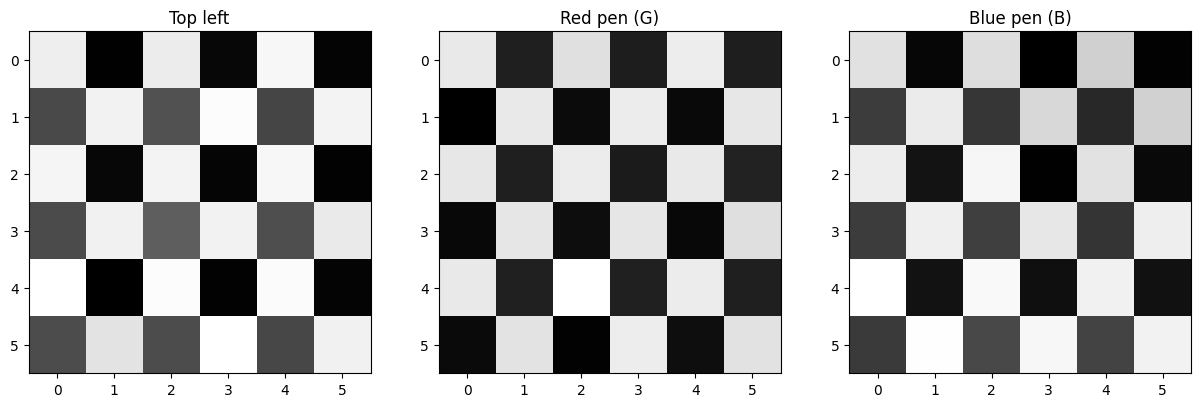

'\nG B  ( from remaining is blue)\nR G\n'

In [4]:
#check top left
print(array[:6, :6])  # Green has bigger values as per hint so diagnoal is green
'''
G - - -
- G - -
'''

#Next we find which one is red
print(array[2102:2108, 1430:1436])

#Next we find which one is blue
print(array[1770:1776, 2600:2606])

# Visualize the subsets for manual inspection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(array[:6, :6], cmap='gray')
axes[0].set_title('Top left')

axes[1].imshow(array[2100:2106, 1430:1436], cmap='gray')
axes[1].set_title('Red pen (G)')
axes[2].imshow(array[1800:1806, 2600:2606], cmap='gray')
axes[2].set_title('Blue pen (B)')
plt.show()

'''
G - G -
- G - G
G - G -
'''
'''
G B  ( from red pattern)
'''

'''
G B  ( from remaining is blue)
R G
'''

Exercise 2

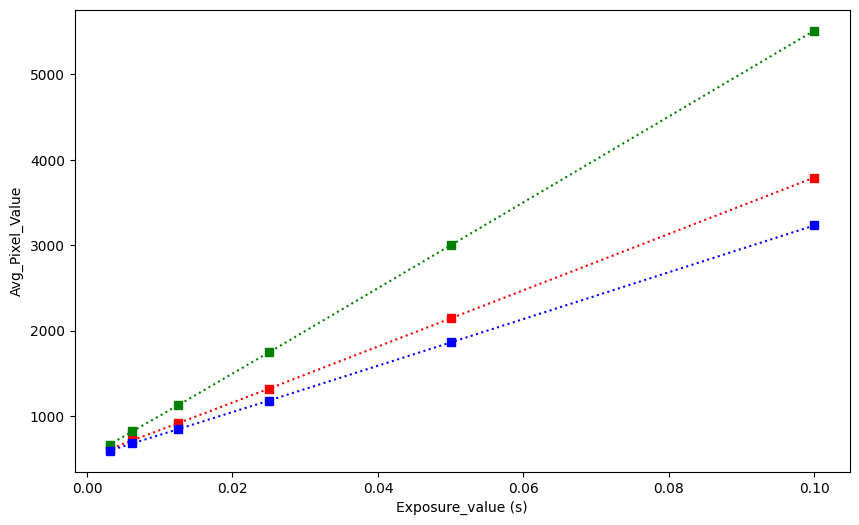

In [5]:
#exercise 2

def check_linearity():
    avg_red_pixels=[]
    avg_green_pixels = []
    avg_blue_pixels = []

    raw_images = ["IMG_3044.CR3","IMG_3045.CR3","IMG_3046.CR3","IMG_3047.CR3","IMG_3048.CR3","IMG_3049.CR3"]

    for i in raw_images:
        raw = rawpy.imread("exercise_2_data/02/" + i)
        array = np.array(raw.raw_image_visible)
        #create bayer pattern mask
        #according to the bayer pattern we found previously
        A_green_elem = [[0,1,0,1],[1,0,1,0]]
        A_red_elem = [[1,0,1,0],[0,0,0,0]]
        A_blue_elem = [[0,0,0,0],[0,1,0,1]]
        reps = (int(array.shape[0]/2), int(array.shape[1]/4))
        green_mask = np.tile(A_green_elem, reps)
        red_mask =  np.tile(A_red_elem, reps)
        blue_mask = np.tile(A_blue_elem, reps)

        #multiply the each mask with the raw image array
        green_values = np.multiply(array, green_mask)
        red_values = np.multiply(array, red_mask)
        blue_values = np.multiply(array, blue_mask)

        avg_red_pixels.append(np.sum(red_values.astype(np.uint64))/np.count_nonzero(red_values))
        avg_green_pixels.append(np.sum(green_values.astype(np.uint64))/np.count_nonzero(green_values))
        avg_blue_pixels.append(np.sum(blue_values.astype(np.uint64))/np.count_nonzero(blue_values))


    exposure = [1/10, 1/20, 1/40, 1/80, 1/160, 1/320]
    plt.figure(figsize=(10, 6))
    plt.plot(exposure, avg_red_pixels, 'r:', label='red_values', marker = 's')
    plt.plot(exposure, avg_green_pixels, 'g:', label='green_values', marker = 's')
    plt.plot(exposure, avg_blue_pixels, 'b:', label='blue_values', marker = 's')
    plt.xlabel('Exposure_value (s)')
    plt.ylabel('Avg_Pixel_Value')
    #plt.legend()
    plt.show()

check_linearity()

Exercise 3

In [6]:
#exercise 3
def demosaicing(array, normalize=True, showall=True):
    #print("shape of the image " + str(array.shape))

    #creating ht emask for each color channels
    A_green_elem = [[0,1,0,1],[1,0,1,0]]
    A_red_elem = [[1,0,1,0],[0,0,0,0]]
    A_blue_elem = [[0,0,0,0],[0,1,0,1]]
    reps = (int(array.shape[0]/2), int(array.shape[1]/4))
    green_mask = np.tile(A_green_elem, reps)
    red_mask =  np.tile(A_red_elem, reps)
    blue_mask = np.tile(A_blue_elem, reps)
    

    #creating kernel as (3,3) as ones matrix
    kernel = np.ones([3,3])

    #color channel C as ((Mc x X)*K)/(Mc*K)
    ##Convoution on Red Channel

    # A = cv2.filter2D(padded_red_array, -1, kernel)
    # B = cv2.filter2D(padded_mask, -1, kernel)
    A = convolve2d(red_mask*array, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    B = convolve2d(red_mask, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    C1 = (A)/(B)

    ##Convolution on Green Channel
    A = convolve2d(green_mask*array, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    B = convolve2d(green_mask, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    C2 = (A)/(B)

    ##Convolution on Blue Channel
    A = convolve2d(blue_mask*array, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    B = convolve2d(blue_mask, kernel, boundary='fill', mode = 'same', fillvalue = 0)
    C3 = (A)/(B)

    #print(C1.shape,C2.shape,C3.shape)

    M = np.dstack((C1,C2,C3))

    rgb_image = M
    if normalize:
      # Normalize the data to the 8-bit range [0, 255]
      rgb_image = (M / M.max()) * 255

      # Cast to uint8 for displaying as an image
      rgb_image = np.clip(rgb_image, 0, 255).astype('uint8')

    if showall:
      #print("shape of the convoluted image " + str(C.shape))
      plt.imshow(C1)
      plt.title('Image for channel Red')
      plt.show()

      plt.imshow(C2)
      plt.title('Image for channel green')
      plt.show()

      plt.imshow(C3)
      plt.title('Image for channel Blue')
      plt.show()

      plt.imshow(rgb_image)
      plt.title('Image after Demosiac')
      plt.show()

    return rgb_image



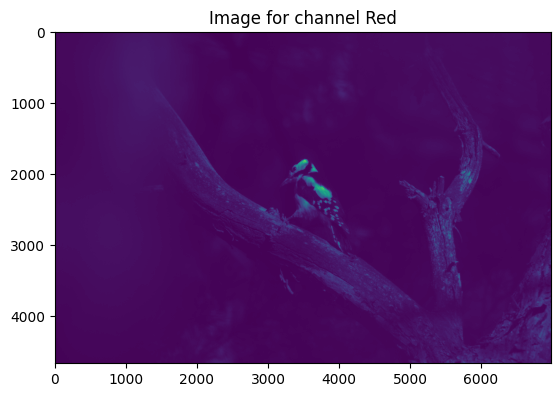

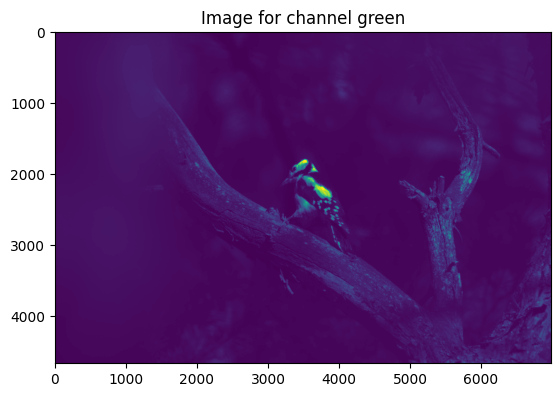

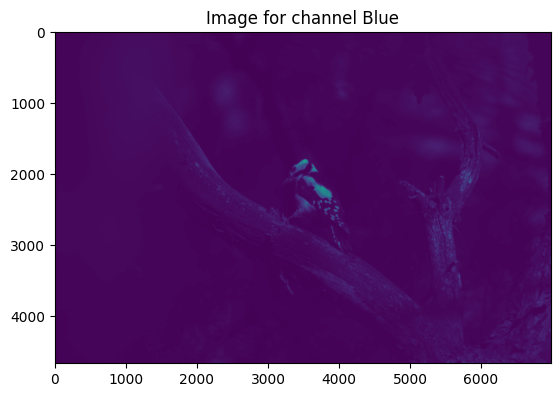

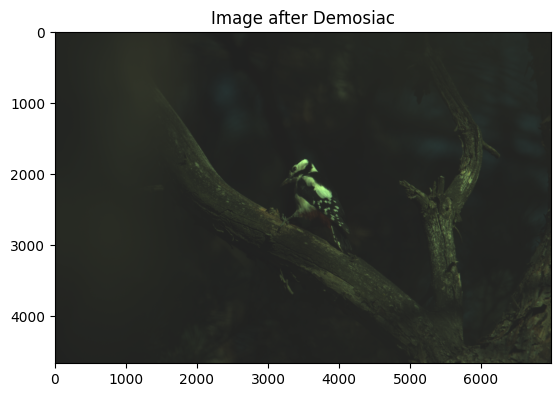

In [7]:
#read our raw
raw = rawpy.imread('exercise_2_data/03/IMG_4782.CR3')
array = np.array(raw.raw_image_visible)
rgb_image= demosaicing(array)

## Exercise 4
Improve the Luminosity. As the image is dark apply gamma correction


In [8]:
#exercise 4
def gamma_correction(data,gamma):
  #normlaize using percentile
  a = np.percentile(data, 0.01)
  b = np.percentile(data, 99.99)
  # Normalize data to [0, 1] range
  data = (data - a) / (b - a)
  # Clip values below 0 to 0 and above 1 to 1
  data[data<0] = 0
  data[data>1] = 1

  #gamma correction
  gamma_corrected = data ** gamma #adjusting the constrast according to the gamma values
  gamma_corrected = (gamma_corrected * 255).astype(np.uint8) #converted to 8 bit unsingned

  #additional function for gamma correction
  gamma_corrected_second = np.sin(data)
  gamma_corrected_second = (gamma_corrected_second * 255).astype(np.uint8)

  return gamma_corrected,gamma_corrected_second



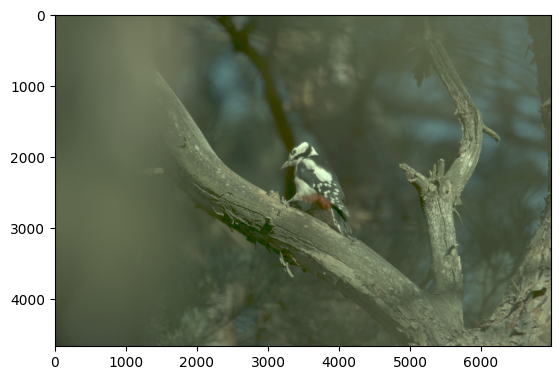

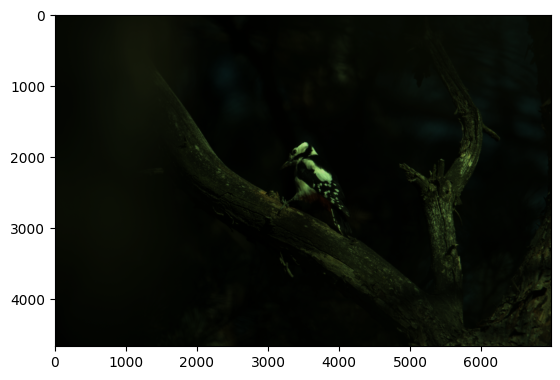

In [9]:
gamma_corrected, gamma_corrected_second = gamma_correction(rgb_image,0.3)
plt.imshow(gamma_corrected)
plt.show()

plt.imshow(gamma_corrected_second)
plt.show()

## Exercise 5
Apply white balance

In [10]:
#exercise 5
def gray_world(bird):
    # mean of all / mean of each band
    bird_gw = ((bird * (bird.mean() / bird.mean(axis=(0, 1)))).clip(0, 255).astype(np.uint8))
    return bird_gw
    #average intensity across each channel is equal to the overall mean intensity

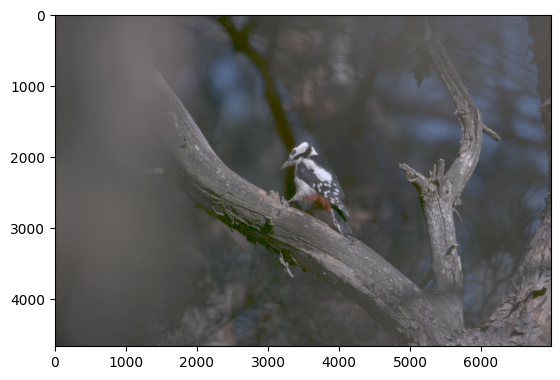

In [11]:
img = gray_world(gamma_corrected)
plt.imshow(img)
plt.show()

## Exercise 6
HDR from multiple images

In [53]:
#exercise 6
def produce_HDR(data, exposure, thresh):
  h = data[0].astype(np.uint) #one with longest exposure
  for i in range(1,len(data)): #other 10

    curr_img = data[i].astype(np.uint)
    #multiply the image by exposure difference between 1st and current
    curr_img = (curr_img.astype(np.float64)*(1/exposure[i])).astype(np.uint) ### exposure difference 
    #converted to the float to to deal with the HDR data without overflow

    #replace if greater than threshhold
    threshold = thresh * np.max(h) #maximum value of a pixel in h multiply to scalaer value
    h[h > threshold] = curr_img[h > threshold] #replacing the pixels above threshhold
  return h

def load_data():
  #load data
  data = []
  for idx in range(0,11):
    data_idx = str(idx)
    if idx < 10:
      data_idx = '0'+str(idx)
    raw = rawpy.imread('exercise_2_data/06/'+data_idx+'.CR3')
    array = np.array(raw.raw_image_visible)
    data.append(array)
  return data

In [29]:
data = load_data()
exposure = [1 / (2 ** i) for i in range(len(data))] # 1 1/2 1/4 1/8  so each time 1/2^i where i 0 to 10
#print(exposure)
hdr_img = produce_HDR(data,exposure)

#apply log scale
hdr_img = np.log(hdr_img)

plt.imshow(hdr_img)
plt.title('Image after HDR')
plt.show()


demos_img = demosaicing(hdr_img, False, False) #demosiac

#normlaize using percentile
a = np.percentile(demos_img, 0.01)
b = np.percentile(demos_img, 99.99)
# Normalize data to [0, 1] range
demos_img = (demos_img - a) / (b - a)
# Clip values below 0 to 0 and above 1 to 1
demos_img[demos_img<0] = 0
demos_img[demos_img>1] = 1

demos_img = (demos_img * 255).astype(np.uint8)

plt.imshow(demos_img)
plt.title('Image after Demosaic')
plt.show()

#gamma_corrected_img, _ = gamma_correction(demos_img,0.3) #gamma_correction
gamma_corrected_img = demos_img
white_balanced = gray_world(gamma_corrected_img)


plt.imshow(white_balanced)
plt.title('Image after Demosaic and White balance')
plt.show()


NameError: name 'load_data' is not defined

## Exercise 7
Implement iCAM06


In [14]:
#exercise 7
def iCAM06(img, output_range=4,d=9,sigmaColor=1,sigmaSpace=1):
    # input intensity of the RGB channels
    intensity = (20*img[:,:,0] + 40*img[:,:,1] + img[:,:,2]) / 61

    # Normalise with respect to intensity
    r, g, b = img[:,:,0] / intensity, img[:,:,1] / intensity, img[:,:,2] / intensity

    # Apply bilateral filter
    log_base = cv2.bilateralFilter(np.log(intensity), d, sigmaColor, sigmaSpace) # try diff parameters
    '''
    large d will take more time but better for smotthing. worse for edges (blurs)
    large sigmacolor helps preserve edge but doesnt help in noise
    large sigmaspace helps preserve edges better
    '''

    # Calculate the detail
    log_detail = np.log(intensity) - log_base

    # compression factor
    compression = np.log(output_range) / (np.max(log_base) - np.min(log_base))

    # offset
    log_offset = -np.max(log_base) * compression

    # Calculate output intensity
    output_intensity = np.exp(log_base * compression + log_offset + log_detail)

    # Adjust the color channels as per new intensity
    img[:,:,0] = r * output_intensity
    img[:,:,1] = g * output_intensity
    img[:,:,2] = b * output_intensity

    # Normalize to 8-bit
    #img *= 255  # Scale to the 8-bit range [0, 255]

    return img

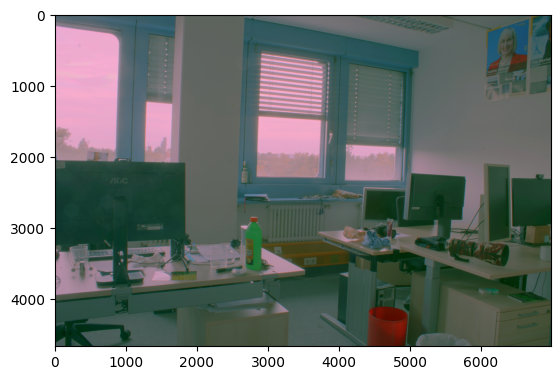

In [15]:
final_img = iCAM06(white_balanced.astype(np.float32))
final_img,_ = gamma_correction(final_img,2.0) # try different gamma 0.3 is not good
plt.imshow(final_img)
plt.show()

## Exercise 8
Add all together and do more!

In [76]:
#test

#additonal enhancements
def enhance_image(image):
    #denoise and unsharp masking comines blur and original image
    Hd_img_denoised= cv2.GaussianBlur(image, (5, 5), 0) #denoise
    sharpened = cv2.addWeighted(image, 1.0 + 1.5, Hd_img_denoised, -1.5, 0)


    # adaptive histogram equalization. enhances image locally not globally so helps keep dark dark and light light sorta
    # Convert image to LAB color space
    lab_image = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    # Split LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply histogram equalization to the L channel (lightness level)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced_l_channel = clahe.apply(l_channel)

    # Apply histogram equalization to the a channel (+green -red values)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced_a_channel = clahe.apply(a_channel)

    # Apply histogram equalization to the b channel (+blue -yellow)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced_b_channel = clahe.apply(b_channel)


    # Merge enhanced L channel with enhanced A and B channels
    enhanced_lab_image = cv2.merge((enhanced_l_channel, enhanced_a_channel, enhanced_b_channel))

    # Convert enhanced LAB image back to BGR color space
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)

    # enhance details with nonrealistic filter
    enhanced_image = cv2.detailEnhance(enhanced_image, sigma_s=10, sigma_r=0.15)

    return enhanced_image

def process_raw(file_path=None, savepath=None, show=False):
  assert file_path!=None
  dir = file_path.rsplit('/',1)[0]
  if savepath==None:
    savepath = dir+'/result.jpg'
    print('Savepath is not given so saving in filepath: '+savepath)
  elif os.path.exists(savepath.rsplit('/',1)[0])==False:
      os.makedirs(savepath.rsplit('/',1)[0])
      print('Savepath '+savepath.rsplit('/',1)[0]+' does not exist so creating it')
  #load image
  print('Image path is '+file_path)
  img_raw = np.array(rawpy.imread(file_path).raw_image_visible)
  print('before MOSAIC')
  if show:
    plt.imshow(img_raw)
    plt.title('Before Demosaic')
    plt.show()
  #apply demosiac
  demos_img= demosaicing(img_raw, False, False)

  #apply gamma correction
  demos_img, _ = gamma_correction(demos_img,0.3)

  #apply white balance
  white_bal_img = gray_world(demos_img)

  #apply ICAM06
  Hd_img = iCAM06(white_bal_img.astype(np.float32),d=1,sigmaColor=0.1,sigmaSpace=0.1) # faster with d=1
  Hd_img,_ = gamma_correction(Hd_img,2.5)
#  Hd_img = (Hd_img * 255).astype(np.uint8)
  print('AFTER MOSAIC')
  if show:
    plt.imshow(Hd_img)
    plt.title('Before Additional Enhancements')
    plt.show()

  #additional enhancement from opencv
  Hd_img = enhance_image(Hd_img)

  print('After All')
  if show:
    plt.imshow(Hd_img)
    plt.title('At end')
    plt.show()

  print('Saving at: '+savepath)
  imageio.imsave(savepath, Hd_img, quality=98)


  return

In [ ]:
#process_raw('exercise_2_data/06/02.CR3','results/result11.jpg') #,show=True is optional to see all plots
'''
Time taken
To load 9sec
MOSAIC, White balance, ICam07 25 sec
Additional enhancements 25 sec
saving time 10 sec
total 1 min 4 sec
'''

'''
tileGridSize nd cliplimit 2.0
result1 with 16 16
result2 with 4 4
result3 with 8 8
result4 with 32 32

tilegrid 4 4
result5 with cliplimit 30
result6 with cliplimit 10
result7 with cliplimit 0.5

result8 with a and b enhanced ------- best
result9 with different sharp parameters alpha = 1.5  beta = -1.2 - its bad

I think best is 2nd

'''

In [3]:
## Bonus Exercise
#estimate the camera luminousity curve y = f(x)
#y = pixel_value
#x = luminosity
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt

def get_exposure_time():
    exposure_times = []
    for i in range(23,35):
        data = "additional-exercise/A45A69" + str(i) + ".jpg"
        image = Image.open(data)
        exif_data = image._getexif()

        if not exif_data:
            return None
    
        for tag, value in exif_data.items():
            decoded = TAGS.get(tag, tag)
            if decoded == 'ExposureTime':
                exposure_times.append(float(value))
    return(np.array(exposure_times))
get_exposure_time()

array([1.30e+01, 6.00e+00, 3.20e+00, 1.60e+00, 8.00e-01, 4.00e-01,
       2.00e-01, 1.00e-01, 5.00e-02, 2.50e-02, 1.25e-02, 6.25e-03])

In [45]:
def normalize_to_range(array, min_value=1, max_value=10):
  min_val = np.min(array)
  max_val = np.max(array)
  normalized_array = (array - min_val) / (max_val - min_val) * (max_value - min_value) + min_value
  return normalized_array

In [70]:
def normalize_to_1_10(values):
    min_value = np.min(values)
    max_value = np.max(values)

    if min_value == max_value:
        return np.zeros_like(values)
    # Apply min-max normalization
    normalized_values = (values - min_value) * 9 / (max_value - min_value) + 1
    return normalized_values

In [47]:
exposure = get_exposure_time()
normalize_to_range(exposure, min_value=1, max_value=10)

array([10.        ,  5.15151515,  3.21212121,  2.1038961 ,  1.54978355,
        1.27272727,  1.13419913,  1.06493506,  1.03030303,  1.01298701,
        1.004329  ,  1.        ])

In [71]:
from scipy.optimize import curve_fit #performs curve fitting on a set of data points
def luminousity_curve(plot):
    
    R_values = []
    B_values = []
    G_values = []
    exposure = get_exposure_time()
    #exposure = normalize_to_range(exposure, min_value=1, max_value=10)
    exposure = normalize_to_1_10(exposure)
    print(exposure)
    #all four arrays above has 12 values

    for i in range(23,35):
        data = "additional-exercise/A45A69" + str(i) + ".jpg"
        array = cv2.imread(data)
        average_intensities = np.mean(array, axis=(0,1))  # Average across rows and columns (all pixels)
        red_avg, green_avg, blue_avg = average_intensities
        R_values.append(red_avg)
        G_values.append(green_avg)
        B_values.append(blue_avg)
    
    def polynomial_func(x, a, b, c):  # Define polynomial function (2nd degree here)
        return a * x**2 + b * x + c

    # Fit polynomial curves using curve_fit
    red_fit_coeffs, *_ = curve_fit(polynomial_func, exposure, R_values, bounds=(0,np.inf))
    green_fit_coeffs, *_ = curve_fit(polynomial_func, exposure, G_values, bounds=(0,np.inf))
    blue_fit_coeffs, *_ = curve_fit(polynomial_func, exposure, B_values, bounds=(0,np.inf))
    print(len(R_values), len(G_values), len(B_values))
    
    #polynomial_func = second degree function can fit the data
    #exposure: independent variable
    #R_value: dependent variable
    #red_fit_coeffs: tuple containing the estimated coefficients of the fitted polynomial for the Red channel
    #red_fit_cov: covariance matrix, can be used to determine the uncertainity in fitting
    
    coeffs = [red_fit_coeffs, green_fit_coeffs, blue_fit_coeffs]

    print(len(red_fit_coeffs), len(green_fit_coeffs), len(blue_fit_coeffs))

    #Generate curves using fitted coefficients
    #red_curve = polynomial_func(exposure, *red_fit_coeffs)
    #green_curve = polynomial_func(exposure, *green_fit_coeffs)
    #blue_curve = polynomial_func(exposure, *blue_fit_coeffs)

    
    plt.figure(figsize=(14, 8))
    #plt.plot(exposure, R_values, 'ro', label='Red (data)', markersize=5)
    #plt.plot(exposure, G_values, 'go', label='Green (data)', markersize=5)
    #plt.plot(exposure, B_values, 'bo', label='Blue (data)', markersize=5)
    plt.plot(exposure, R_values, 'r-', label='Red (fit)')
    plt.plot(exposure, G_values, 'g-', label='Green (fit)')
    plt.plot(exposure, B_values, 'b-', label='Blue (fit)')
    plt.xlabel('Exposure')
    plt.ylabel('Avg Pixel Value')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    if plot==True:
        plt.show()
    else:
        print("Not Today!")
        plt.close()
    return coeffs

In [67]:
def polynomial_func(x, a, b, c):  # Define polynomial function (2nd degree here)
        return a * x**2 + b * x + c

[10.          5.15151515  3.21212121  2.1038961   1.54978355  1.27272727
  1.13419913  1.06493506  1.03030303  1.01298701  1.004329    1.        ]
12 12 12
3 3 3


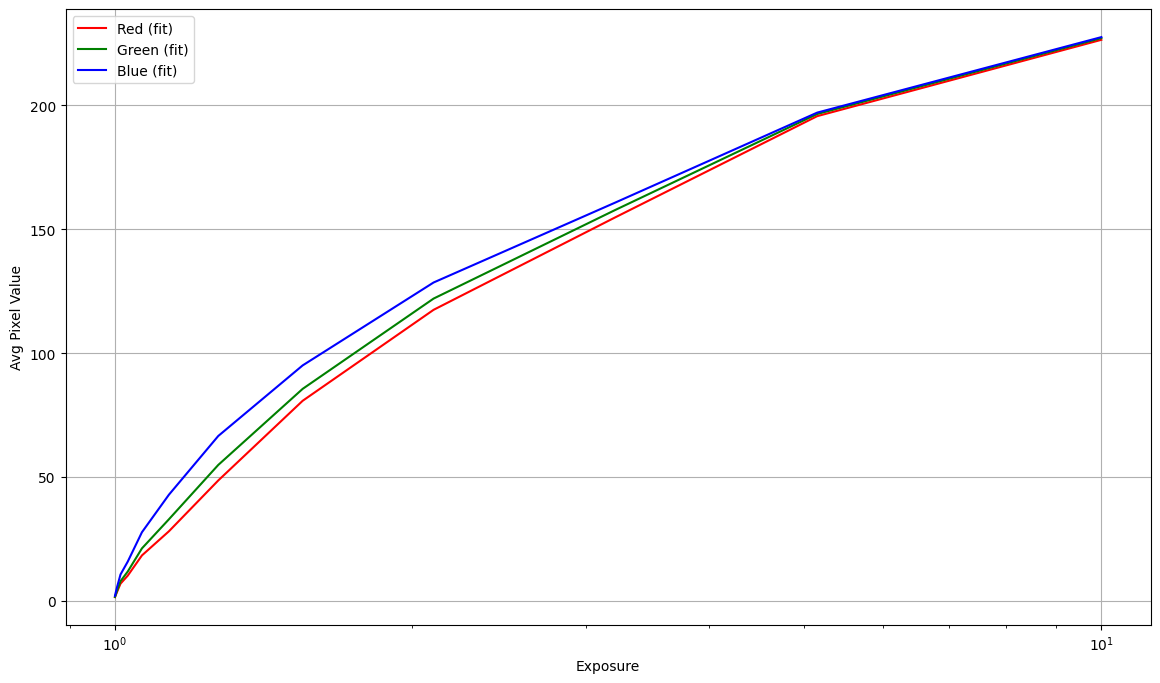

[array([1.00492086e-24, 2.63144300e+01, 9.59283019e+00]),
 array([3.71403919e-18, 2.60786630e+01, 1.27561011e+01]),
 array([1.43213510e-18, 2.54132553e+01, 1.91115855e+01])]

In [72]:
luminousity_curve(True)
#LUMINOSITY CURVE: relationship between the intensity of light (luminance) hitting the sensor and the recorded pixel value in an image

12 12 12
3 3 3
Not Today!
<class 'list'>


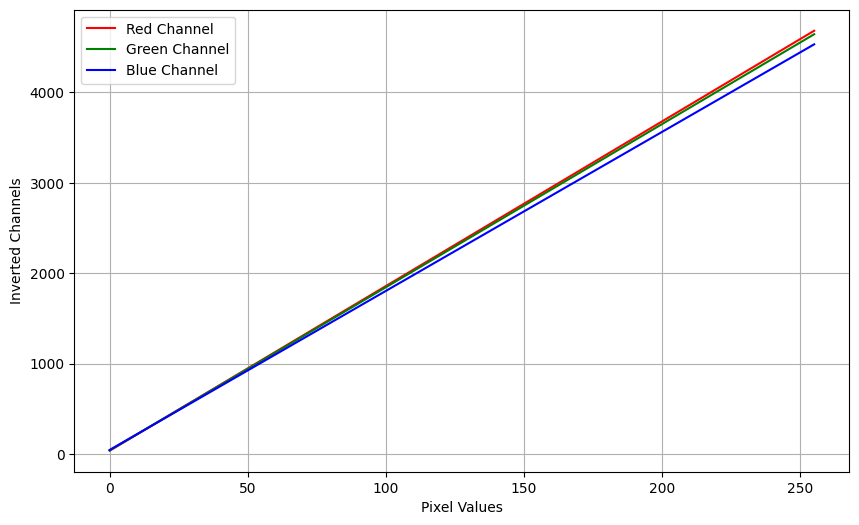

256 256 256


(array([  35.79334478,   54.01978978,   72.24623477,   90.47267976,
         108.69912475,  126.92556974,  145.15201473,  163.37845972,
         181.60490471,  199.8313497 ,  218.0577947 ,  236.28423969,
         254.51068468,  272.73712967,  290.96357466,  309.19001965,
         327.41646464,  345.64290963,  363.86935462,  382.09579962,
         400.32224461,  418.5486896 ,  436.77513459,  455.00157958,
         473.22802457,  491.45446956,  509.68091455,  527.90735954,
         546.13380454,  564.36024953,  582.58669452,  600.81313951,
         619.0395845 ,  637.26602949,  655.49247448,  673.71891947,
         691.94536446,  710.17180946,  728.39825445,  746.62469944,
         764.85114443,  783.07758942,  801.30403441,  819.5304794 ,
         837.75692439,  855.98336938,  874.20981438,  892.43625937,
         910.66270436,  928.88914935,  947.11559434,  965.34203933,
         983.56848432, 1001.79492931, 1020.0213743 , 1038.24781929,
        1056.47426429, 1074.70070928, 1092.92715

In [21]:
#do it again
def inverse_graph():
    pixel_values = np.linspace(0, 255, 256)
    coeffs = luminousity_curve(False)
    print(type(coeffs))
    #print(*coeffs[0].shape)
    
    inverse_red = []
    inverse_green = []
    inverse_blue = []

# Iterate over each pixel value to apply inverse function to each values 
    #for y in pixel_values:
    # Calculate the inverse value for the red channel and append to the list
    inverse_red = polynomial_func(pixel_values, *coeffs[0])
    
    #inverse_red.append(inv_red)

# Calculate the inverse value for the green channel and append to the list
    inverse_green = polynomial_func(pixel_values, *coeffs[1])
    #inverse_green.append(inv_green)

# Calculate the inverse value for the blue channel and append to the list
    inverse_blue = polynomial_func(pixel_values, *coeffs[2])
    #inverse_blue.append(inv_blue)

    ##### get rid of nan values #####
    #inverse_red = [x if not np.isnan(x) else 0 for x in inverse_red]
    #inverse_green = [x if not np.isnan(x) else 0 for x in inverse_green]
    #inverse_blue = [x if not np.isnan(x) else 0 for x in inverse_blue]
    # inverse_red = replace_nan_with_previous(inverse_red)
    # inverse_green = replace_nan_with_previous(inverse_green)
    # inverse_blue = replace_nan_with_previous(inverse_blue)



    #although i have a option to repeat the previous values because mean is distorting the graph
    
    plt.figure(figsize=(10, 6))
    plt.plot(pixel_values, inverse_red, 'r-', label='Red Channel')
    plt.plot(pixel_values, inverse_green, 'g-', label='Green Channel')
    plt.plot(pixel_values, inverse_blue, 'b-', label='Blue Channel')
    #plt.title(title)
    plt.xlabel('Pixel Values')
    plt.ylabel('Inverted Channels')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(len(inverse_red), len(inverse_green), len(inverse_blue))
    return inverse_red, inverse_green, inverse_blue #tuple of list

inverse_graph()
    

In [8]:
images = []
for i in range(23,35):
    #data = "additional-exercise/A45A69" + str(i) + ".jpg" #converting to backslash \ for specific purpose 
    data = "additional-exercise\A45A69" + str(i) + ".jpg"
    images.append(data)
print(images)

['additional-exercise\\A45A6923.jpg', 'additional-exercise\\A45A6924.jpg', 'additional-exercise\\A45A6925.jpg', 'additional-exercise\\A45A6926.jpg', 'additional-exercise\\A45A6927.jpg', 'additional-exercise\\A45A6928.jpg', 'additional-exercise\\A45A6929.jpg', 'additional-exercise\\A45A6930.jpg', 'additional-exercise\\A45A6931.jpg', 'additional-exercise\\A45A6932.jpg', 'additional-exercise\\A45A6933.jpg', 'additional-exercise\\A45A6934.jpg']


In [12]:
import cv2 as cv
import numpy as np
# Loading exposure images into a list
#img_fn = [r"C:\Users\felipe.cunha\Documents\venv\HDRTest\100.jpg", r"C:\Users\felipe.cunha\Documents\venv\HDRTest\250.jpg", r"C:\Users\felipe.cunha\Documents\venv\HDRTest\500.jpg"]
img_fn = [r'additional-exercise\A45A6923.jpg', r'additional-exercise\A45A6924.jpg', r'additional-exercise\A45A6925.jpg', r'additional-exercise\A45A6926.jpg', r'additional-exercise\A45A6927.jpg', 
            r'additional-exercise\A45A6928.jpg', r'additional-exercise\A45A6929.jpg', r'additional-exercise\A45A6930.jpg', r'additional-exercise\A45A6931.jpg', r'additional-exercise\A45A6932.jpg', 
            r'additional-exercise\A45A6933.jpg', r'additional-exercise\A45A6934.jpg']
img_list = [cv.imread(fn) for fn in img_fn]
exposure_times = get_exposure_time().astype(np.float32)
 #dtype=np.float32)
# Merge exposures to HDR image
merge_debevec = cv.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy())

# Tonemap HDR image to save itinto 8 bit images to show it to LDR display
tonemap1 = cv.createTonemap(gamma=3)
ldr = tonemap1.process(hdr_debevec.copy())
#res_debevec = tonemap1.process(hdr_debevec.copy())
# Exposure fusion using Mertens
merge_mertens = cv.createMergeMertens()
fusion_mertens = merge_mertens.process(img_list)

# Convert datatype to 8-bit and save
res_debevec_8bit = np.clip(ldr*255, 0, 255).astype('uint8')
res_mertens_8bit = np.clip(fusion_mertens*255, 0, 255).astype('uint8')

cv.imwrite(r"C:\Users\vicky\Downloads\Project_Computer_Vision\Project_2\ldr_debevec.jpg", res_debevec_8bit)
cv.imwrite(r"C:\Users\vicky\Downloads\Project_Computer_Vision\Project_2\fusion_mertens.jpg", res_mertens_8bit)

In [23]:
images = []
for i in range(23,35):
    #data = "additional-exercise/A45A69" + str(i) + ".jpg" #converting to backslash \ for specific purpose 
    data = "additional-exercise\A45A69" + str(i) + ".jpg"
    images.append(data)
print(images)

['additional-exercise\\A45A6923.jpg', 'additional-exercise\\A45A6924.jpg', 'additional-exercise\\A45A6925.jpg', 'additional-exercise\\A45A6926.jpg', 'additional-exercise\\A45A6927.jpg', 'additional-exercise\\A45A6928.jpg', 'additional-exercise\\A45A6929.jpg', 'additional-exercise\\A45A6930.jpg', 'additional-exercise\\A45A6931.jpg', 'additional-exercise\\A45A6932.jpg', 'additional-exercise\\A45A6933.jpg', 'additional-exercise\\A45A6934.jpg']


[10.          5.15151515  3.21212121  2.1038961   1.54978355  1.27272727
  1.13419913  1.06493506  1.03030303  1.01298701  1.004329    1.        ]
12 12 12
3 3 3
Not Today!
[10.          5.15151515  3.21212121  2.1038961   1.54978355  1.27272727
  1.13419913  1.06493506  1.03030303  1.01298701  1.004329    1.        ]
12 12 12
3 3 3
Not Today!
<class 'list'>


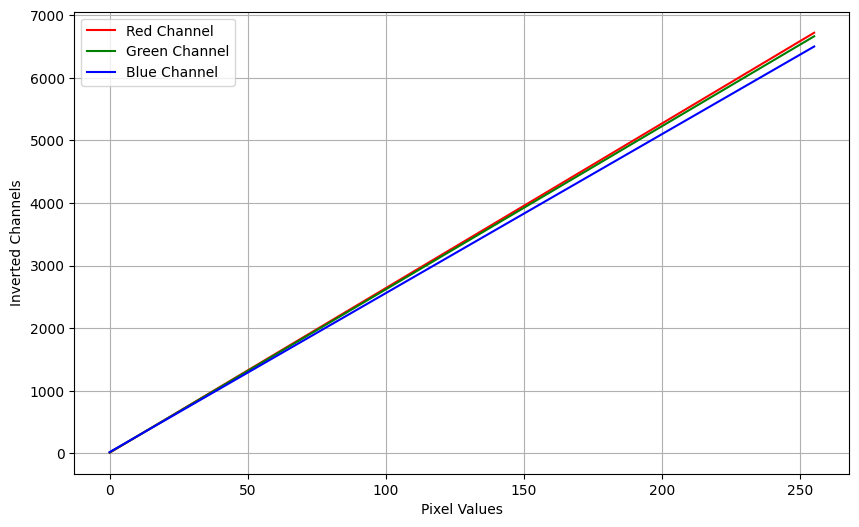

256 256 256
12


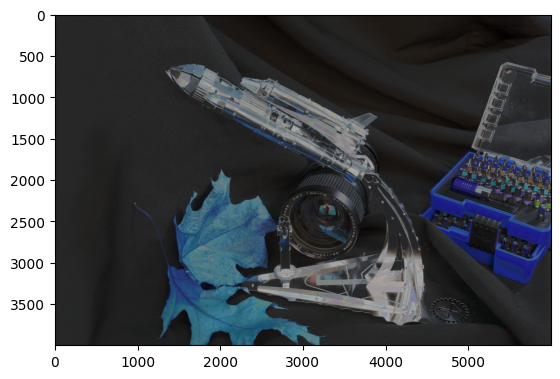

array([[[ 42,  41,  40],
        [ 42,  41,  40],
        [ 42,  42,  41],
        ...,
        [135, 151, 148],
        [135, 150, 148],
        [135, 150, 148]],

       [[ 42,  41,  40],
        [ 32,  42,  41],
        [ 33,  42,  41],
        ...,
        [134, 151, 148],
        [135, 150, 148],
        [135, 150, 148]],

       [[ 42,  41,  40],
        [ 31,  42,  41],
        [ 32,  42,  41],
        ...,
        [134, 151, 148],
        [134, 150, 148],
        [134, 150, 148]],

       ...,

       [[ 37,  39,  40],
        [ 38,  39,  40],
        [ 38,  39,  41],
        ...,
        [ 29,  42,  42],
        [ 30,  33,  31],
        [ 36,  39,  37]],

       [[ 37,  39,  40],
        [ 38,  39,  40],
        [ 38,  39,  41],
        ...,
        [ 41,  40,  40],
        [ 42,  42,  42],
        [ 42,  41,  41]],

       [[ 37,  39,  40],
        [ 38,  39,  40],
        [ 38,  39,  41],
        ...,
        [ 40,  39,  39],
        [ 41,  41,  41],
        [ 42,  41,  41]]

In [77]:
def convert_to_255(poly_value):

  min_val = np.min(poly_value)
  max_val = np.max(poly_value)
  normalized_array = (poly_value - min_val) / (max_val - min_val) * 255
  normalized_array = normalized_array.astype(np.uint8)
  return normalized_array

def result():
    # Load data and exposure values
    data = images
    exposure = get_exposure_time()
    #exposure = normalize_to_range(exposure, min_value=1, max_value=10)
    exposure = normalize_to_1_10(exposure)
    coeffs = luminousity_curve(False)
    
    # Apply inverse gamma correction
    inverse_red, inverse_green, inverse_blue = inverse_graph()
    
    #Convert each image to linear scale
    linear_data = []
    for i,img in enumerate(data):
        img = cv2.imread(img)
        img[:, :, 0] = convert_to_255(polynomial_func(img[:, :, 0], *coeffs[0]))
        img[:, :, 1] = convert_to_255(polynomial_func(img[:, :, 1], *coeffs[1]))
        img[:, :, 2] = convert_to_255(polynomial_func(img[:, :, 2], *coeffs[2]))
        #linear_img = np.stack([img_red, img_green, img_blue], axis=-1)
        #linear_img = inverse_gamma_correction(linear_img)
        cv2.imwrite('HDR_image_{}.jpg'.format(i), img.astype(np.uint8))
        linear_data.append(img)
        

    print(len(linear_data))

    #rgb = np.dstack((inverse_red, inverse_green, inverse_blue))
    
    # Produce HDR image
    hdr_image = produce_HDR(linear_data, exposure, 0.7)
    
    # Display the HDR image
    plt.imshow(hdr_image.astype(np.uint8))
    cv2.imwrite('HDR_image_final.jpg', hdr_image.astype(np.uint8))
    plt.show()
    return hdr_image

result()

[10.          5.15151515  3.21212121  2.1038961   1.54978355  1.27272727
  1.13419913  1.06493506  1.03030303  1.01298701  1.004329    1.        ]
12 12 12
3 3 3
Not Today!
[10.          5.15151515  3.21212121  2.1038961   1.54978355  1.27272727
  1.13419913  1.06493506  1.03030303  1.01298701  1.004329    1.        ]
12 12 12
3 3 3
Not Today!
<class 'list'>


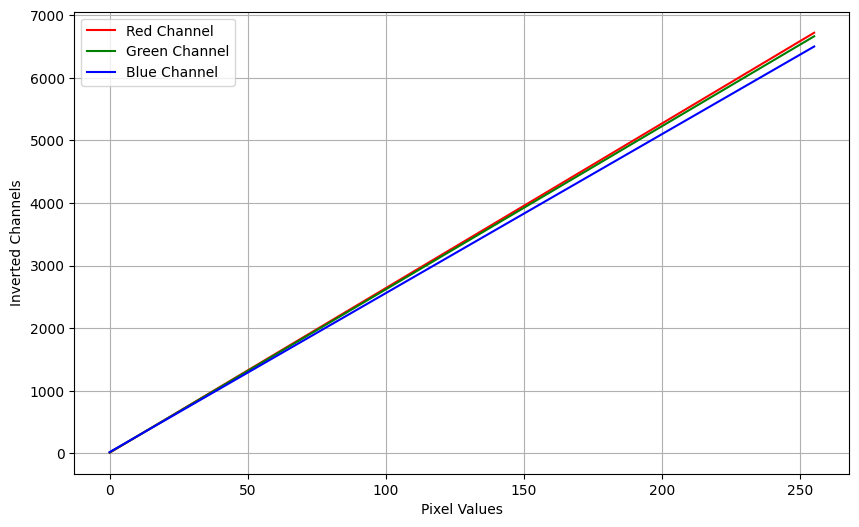

256 256 256
12


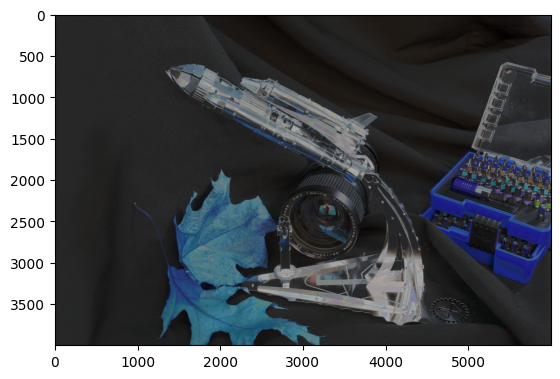

array([[[107,  80,  75],
        [103,  70,  66],
        [132, 104, 100],
        ...,
        [157, 200, 189],
        [157, 200, 188],
        [157, 200, 188]],

       [[ 97,  71,  67],
        [ 38,  77,  69],
        [ 60,  94,  84],
        ...,
        [153, 201, 190],
        [157, 200, 189],
        [157, 200, 189]],

       [[ 98,  71,  67],
        [ 38,  77,  69],
        [ 60,  95,  78],
        ...,
        [153, 201, 190],
        [156, 195, 197],
        [157, 201, 189]],

       ...,

       [[ 84,  83,  72],
        [ 93,  82,  72],
        [ 90,  83,  76],
        ...,
        [ 78, 124,  94],
        [  0,   0,   0],
        [ 64,  69,   5]],

       [[ 84,  83,  72],
        [ 93,  82,  72],
        [ 90,  83,  76],
        ...,
        [121,  91,  58],
        [148, 137, 102],
        [135, 113,  80]],

       [[ 84,  83,  72],
        [ 93,  82,  72],
        [ 90,  83,  76],
        ...,
        [ 98,  78,  33],
        [111, 100,  67],
        [124,  98,  70]]

In [80]:
image = result()
enhance_image(image.astype(np.uint8))